# Getting Started 3: Classic Machine Learning for Cybersecurity

**Open notebook on:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/clandolt)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/)   
**Author:** Christoph R. Landolt


In this tutorial, we will use **basic machine learning algorithms** to gain insights into network traffic and detect potential cyber attacks. We’ll demonstrate:

- **Data preprocessing**
- **Feature extraction**
- **Training a classic ML model with scikit-learn**
- **Evaluating the model**

## Supervised Learning with the KDDCUP99 Dataset

The [KDDCUP99 dataset](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) is a benchmark dataset for **network intrusion detection**.  
It contains simulated network traffic labeled as either *normal* or *attack*.

In this example, we’ll train a simple model to detect anomalies (potential cyber attacks).

In [ ]:
### Importing required libraries

import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


**Notes:**
- `pandas` and `numpy` are used for data loading and manipulation.  
- `matplotlib` and `seaborn` handle visualization.  
- `IsolationForest` is a tree-based model ideal for **outlier detection** (useful in cybersecurity anomaly detection).


### Make a Prediction

#### Step 1: Load and Explore the KDDCUP99 Dataset

The **KDDCUP99 dataset** is a benchmark for evaluating intrusion detection systems.  
It contains labeled network traffic data — distinguishing between *normal* and *attack* connections.

We’ll use a subset (`SA`) of the data to keep computation manageable.



10065 datapoints with 338 anomalies (3.36%)


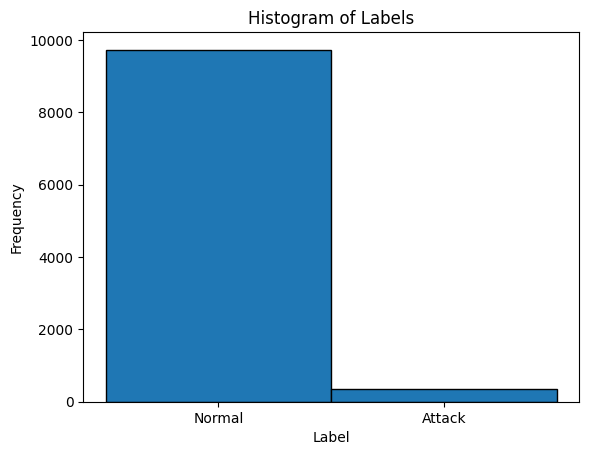

In [17]:
# Load KDD Cup 99 dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, y = datasets.fetch_kddcup99(
    subset="SA",             # Use the 'SA' subset (smaller sample)
    percent10=True,          # Use 10% of the full dataset for efficiency
    random_state=42,         # Ensure reproducibility
    return_X_y=True,         # Return data and labels separately
    as_frame=True            # Load as pandas DataFrame
)

# Convert binary label: 1 = attack, 0 = normal
y = (y != b"normal.").astype(np.int32)

# Take only 10% of the data for quick demonstration
X, _, y, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)

# Display dataset stats
n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

# Plot label distribution
plt.hist(y, bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0, 1], ['Normal', 'Attack'])
plt.title('Histogram of Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()


**Notes:**

- `fetch_kddcup99()` conveniently downloads and loads the dataset from scikit-learn’s built-in datasets.  
- Labels are converted from text (`b"normal."`, `b"attack"`) to integers (`0` and `1`).  
- The histogram provides a quick look at **class imbalance**, which is typical in cybersecurity data — attacks are rarer than normal events.  
- Using only 10% of the dataset keeps the demo lightweight while preserving statistical patterns.


#### Step 2: Data Preprocessing

Before training, categorical (non-numeric) features must be converted into numerical form.
We’ll use **one-hot encoding** with `pandas.get_dummies()`.


In [18]:
# Convert categorical variables to numerical format
X = pd.get_dummies(X)

print(f"Feature matrix shape after encoding: {X.shape}")
X.head()


Feature matrix shape after encoding: (10065, 6536)


,duration_0,duration_1,duration_2,duration_3,duration_4,duration_5,duration_6,duration_7,duration_8,duration_9,...,dst_host_srv_rerror_rate_0.91,dst_host_srv_rerror_rate_0.92,dst_host_srv_rerror_rate_0.93,dst_host_srv_rerror_rate_0.94,dst_host_srv_rerror_rate_0.95,dst_host_srv_rerror_rate_0.96,dst_host_srv_rerror_rate_0.97,dst_host_srv_rerror_rate_0.98,dst_host_srv_rerror_rate_0.99,dst_host_srv_rerror_rate_1.0
26890,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35471,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
37027,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
80164,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
73649,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Notes:**
- Many columns in KDDCUP99 are categorical (e.g., protocol type, service, flag).
- One-hot encoding converts these categories into binary vectors, making them compatible with ML models.


### Step 3: Train-Test Split

We split the dataset into **training (80%)** and **testing (20%)** subsets.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 8052
Testing samples: 2013


#### Step 4: Model Training – Isolation Forest

We use **Isolation Forest**, a classic unsupervised anomaly detection algorithm.  
It identifies unusual data points (potential attacks) by isolating them in a decision tree ensemble.


In [20]:
# Train Isolation Forest for anomaly detection
clf = IsolationForest(contamination=0.1, random_state=42)
clf.fit(X_train)


,n_estimators,100
,max_samples,'auto'
,contamination,0.1
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


**Notes:**
- `contamination` estimates the expected fraction of anomalies.
- The algorithm isolates anomalies faster because they are easier to separate from normal data.


#### Step 5: Make Predictions and Evaluate the Model


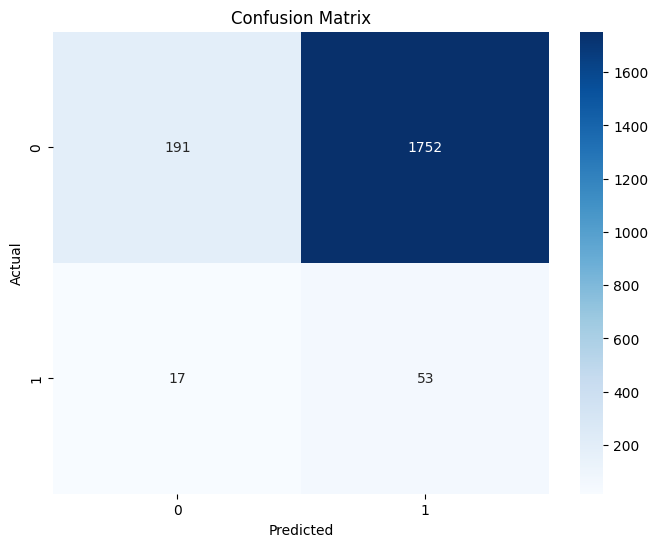

In [21]:
# Predict outliers in the test set
y_pred = clf.predict(X_test)

# Convert predictions to binary format (1 = normal, 0 = anomaly)
y_pred_binary = [1 if pred == 1 else 0 for pred in y_pred]

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**Notes:**
- The confusion matrix shows **true positives**, **false positives**, **true negatives**, and **false negatives**.
- A perfect model would have all predictions along the diagonal.
- Since this is an anomaly detection model, some misclassifications are expected.


### Step 6: Visualize Feature Space with PCA

To understand how the model separates normal vs attack samples,  
we can project the high-dimensional data into **2D space** using **Principal Component Analysis (PCA)**.


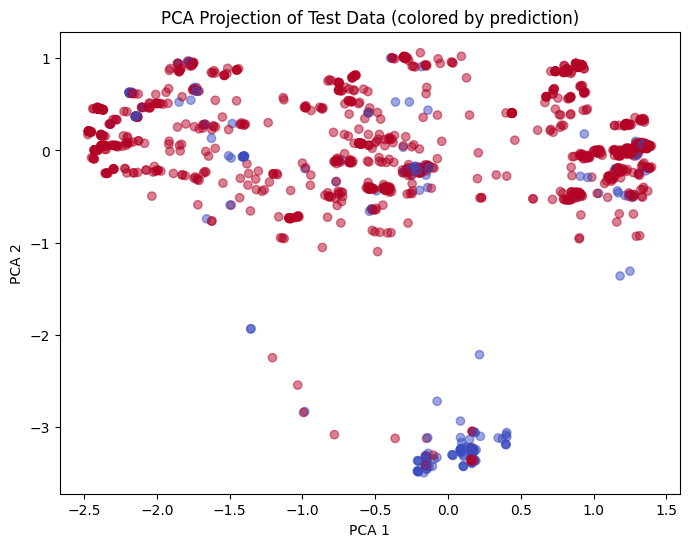

In [22]:
# Apply PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_test)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y_pred_binary, cmap='coolwarm', alpha=0.5)
plt.title('PCA Projection of Test Data (colored by prediction)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


**Notes:**
- PCA reduces the feature space to two dimensions for visualization.
- Points are colored by prediction: **normal (blue)** and **attack (red)**.
- You can often see separable clusters corresponding to different traffic patterns.


## Detect Outliers

In this section, we compare several **classic anomaly detection algorithms** on a 2D representation of the **KDDCUP99** cybersecurity dataset.

Anomaly detection (or outlier detection) is a core task in cybersecurity, as many attacks are characterized by rare or unusual patterns in network traffic.

We’ll visualize how different algorithms identify such anomalies after reducing the dataset to two dimensions using **PCA**.


In [23]:
# Example adapted from:
# https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Load KDDCup99 dataset (subset for simplicity)
from sklearn import datasets
kddcup99 = datasets.fetch_kddcup99(subset='SA', percent10=True)

# Extract data and labels
X = kddcup99.data
y = kddcup99.target


**Notes:**
- The **KDDCUP99** dataset is widely used for network intrusion detection research.
- It contains both categorical and numerical features.
- The `subset='SA'` option loads a smaller portion for faster experimentation.


### Step 1: Preprocessing the Data
We convert **categorical features** to numerical format using **one-hot encoding**.


In [24]:
# Convert categorical features into numerical form
enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(X)


**Notes:**
- `OneHotEncoder` transforms non-numeric columns (like protocol types) into binary vectors.
- `handle_unknown='ignore'` ensures that unseen categories at prediction time don’t cause errors.


### Step 2: Reduce Dimensionality for Visualization
Since the dataset has many features, we use **PCA** (Principal Component Analysis) to project it into **2D space**.


In [25]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())


**Notes:**
- PCA helps visualize how algorithms distinguish between normal and anomalous data.
- Each data point is now represented by two principal components capturing most of the variance.


### Step 3: Define Experiment Parameters
We set up a small synthetic experiment by adding random outliers to the PCA-reduced data.


In [26]:
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers


**Notes:**
- `outliers_fraction` defines the expected proportion of anomalies.
- We’ll later add artificial outliers to make the comparison more visual.


### Step 4: Define and Configure Anomaly Detection Algorithms
We will compare several popular outlier detection methods:
- **EllipticEnvelope (Robust Covariance)**
- **One-Class SVM**
- **SGD One-Class SVM (approximated with Nystroem kernel)**
- **Isolation Forest**
- **Local Outlier Factor**


In [27]:
# Define anomaly detection models
anomaly_algorithms = [
    (
        "Robust covariance",
        EllipticEnvelope(contamination=outliers_fraction, random_state=42),
    ),
    (
        "One-Class SVM",
        svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1),
    ),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]


**Notes:**
- Each algorithm uses a different approach:
  - **EllipticEnvelope** fits an ellipse to data assuming Gaussian distribution.
  - **One-Class SVM** learns a boundary separating normal from anomalous data.
  - **Isolation Forest** isolates anomalies via random decision trees.
  - **Local Outlier Factor (LOF)** measures local density deviation.
- Using multiple algorithms allows you to understand trade-offs in speed and accuracy.


### Step 5: Run the Algorithms and Visualize Results
We apply each method to the dataset and visualize their decision boundaries.


/Users/christophlandolt/.pyenv/versions/mlcysec25/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/Users/christophlandolt/.pyenv/versions/mlcysec25/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


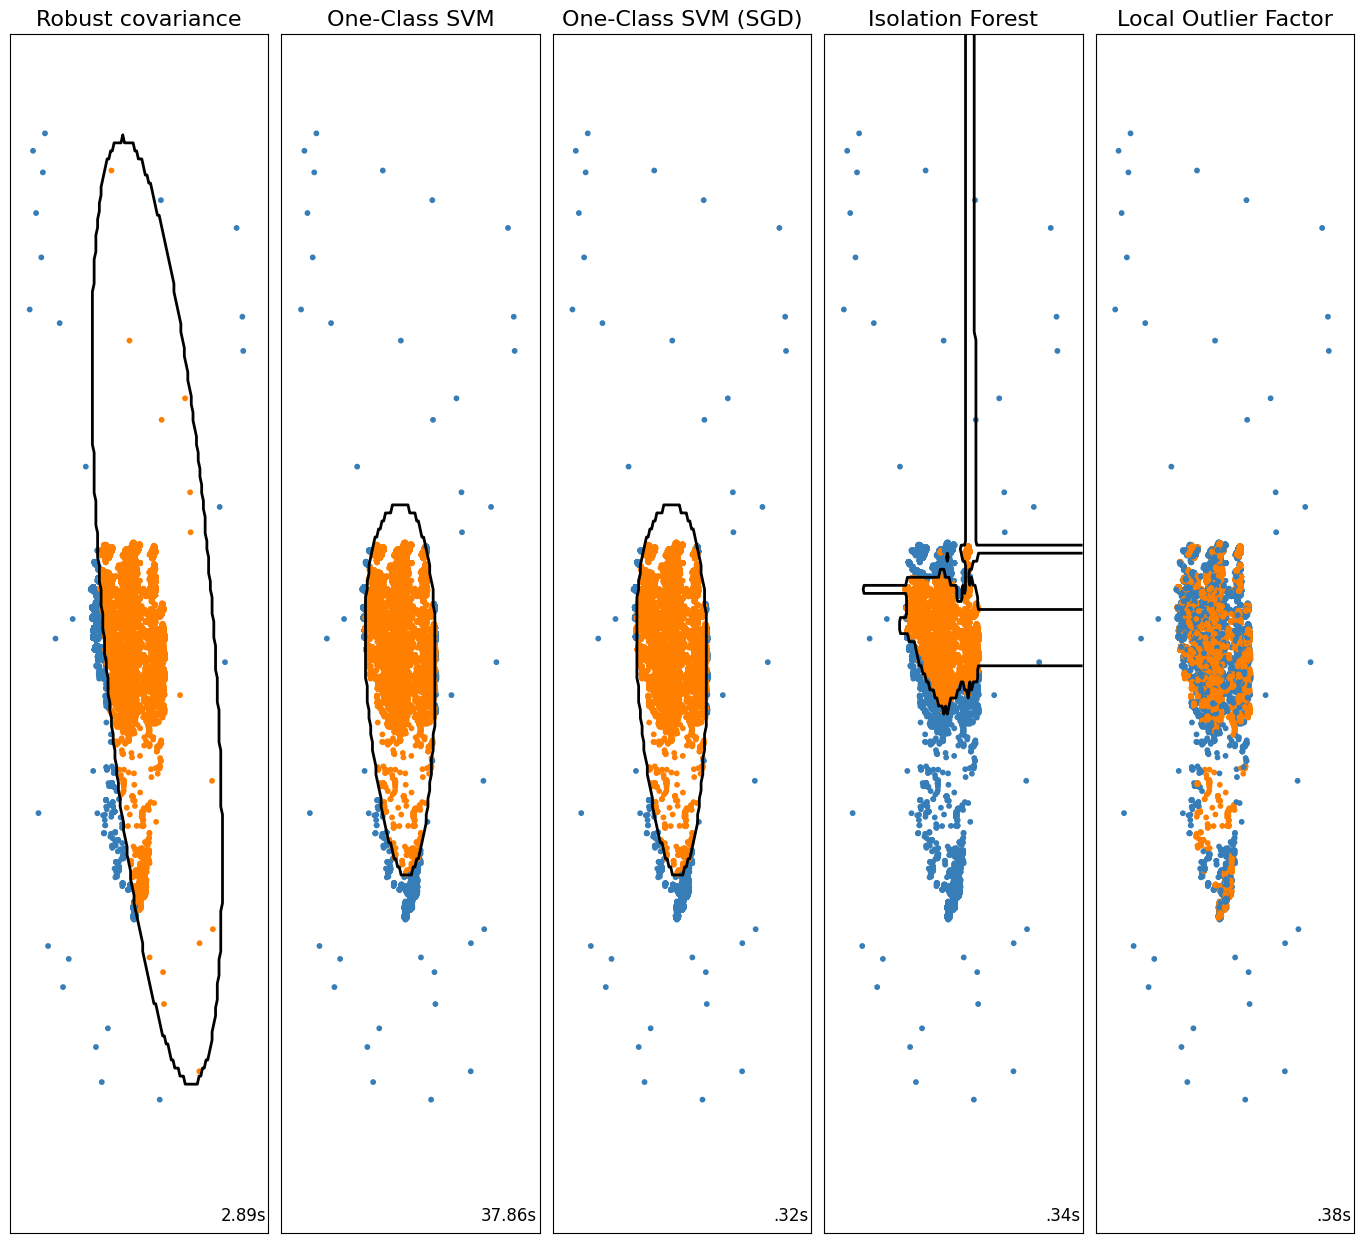

In [28]:
datasets = [X_pca]
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add random outliers for visualization
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()

        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=16)

        # Predict outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # Draw decision boundary
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        # Plot data points
        colors = np.array(["#377eb8", "#ff7f00"])  # Blue: normal, Orange: anomaly
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=12,
            horizontalalignment="right",
        )

        plot_num += 1

plt.show()


**Notes:**
- The contour lines represent the model’s decision boundaries between normal and anomalous regions.
- Points in **orange** are detected as outliers.
- The time in each subplot corner shows how long the model took to fit and predict.
- This comparison highlights:
  - **Speed** (e.g., Isolation Forest is often fastest)
  - **Smoothness** (e.g., SVM-based models yield clean boundaries)
  - **Sensitivity** (LOF and Isolation Forest can detect local deviations)

### Step 6: Evaluate and Compare Outlier Detection Performance

To quantify how well each algorithm detects anomalies,  
we can compute a **confusion matrix** comparing the model’s predictions to the true labels.

This allows us to measure:
- **True Positives (TP)** — correctly detected anomalies  
- **False Positives (FP)** — normal points incorrectly flagged as anomalies  
- **True Negatives (TN)** — correctly identified normal points  
- **False Negatives (FN)** — anomalies missed by the model


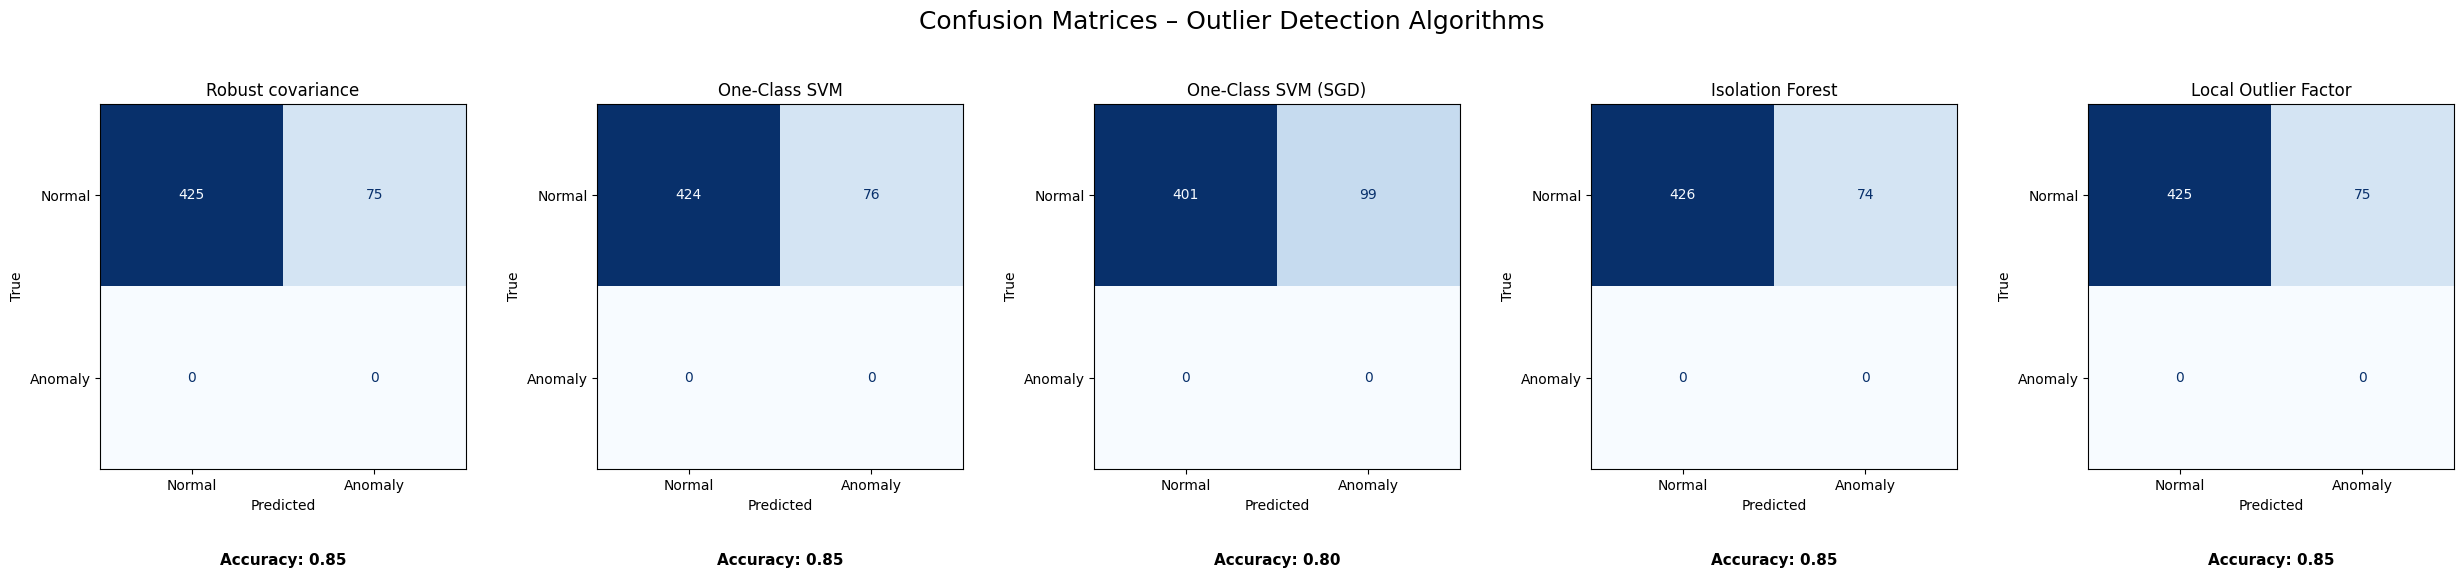

In [ ]:
# Reduce to smaller sample for evaluation
X_eval = X_pca[:500]
y_eval = y[:500]
y_eval_binary = (y_eval != b'normal.').astype(int)  # 1 = anomaly, 0 = normal

# Create subplot grid
n_algos = len(anomaly_algorithms)
fig, axes = plt.subplots(1, n_algos, figsize=(5 * n_algos, 5))
fig.suptitle("Confusion Matrices – Outlier Detection Algorithms", fontsize=18, y=1.08)

results = []

for ax, (name, algorithm) in zip(axes, anomaly_algorithms):
    try:
        # Fit and predict
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X_eval)
        else:
            y_pred = algorithm.fit(X_eval).predict(X_eval)

        # Convert predictions to binary: -1 → anomaly (1), 1 → normal (0)
        y_pred_binary = np.where(y_pred == -1, 1, 0)

        # Compute confusion matrix and accuracy
        cm = confusion_matrix(y_eval_binary, y_pred_binary)
        acc = accuracy_score(y_eval_binary, y_pred_binary)
        results.append((name, cm, acc))

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
        disp.plot(ax=ax, cmap="Blues", colorbar=False)
        ax.set_title(name, fontsize=12)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

        # Show accuracy below each plot
        ax.text(
            0.5, -0.25,
            f"Accuracy: {acc:.2f}",
            ha="center", va="center", transform=ax.transAxes,
            fontsize=11, color="black", fontweight="bold"
        )

    except Exception as e:
        ax.axis("off")
        ax.text(
            0.5, 0.5,
            f"{name}\nfailed:\n{e}",
            ha="center", va="center", fontsize=10, color="red"
        )

plt.tight_layout()
plt.show()


**Notes:**
- We convert labels and predictions into **binary format**:  
  - `0` → Normal  
  - `1` → Anomaly
- Each confusion matrix shows how many samples were correctly or incorrectly classified.
- Blue intensity corresponds to the number of samples in each category.
